# Given the poster, can you tell if a movie is a thriller or not?

## Imports

In [3]:
%load_ext autoreload
%autoreload 2

from mxnet import gluon, init, nd, autograd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo
from mxnet.gluon import utils as gutils
import subprocess
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from skimage import io

import mxnet as mx
from mxnet import lr_scheduler
import pandas as pd
import os
import cv2

FOLDER = '/tmp/data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preparing the movies-posters dataset

In [6]:
df = pd.read_csv(os.path.join(FOLDER, 'MovieGenre.csv'), encoding='latin1')
df = df.drop_duplicates()
df = df.loc[~pd.isnull(df.Genre)]
df.shape

(39370, 6)

In [7]:
df['split_genres'] = df.Genre.str.split('|')
df['abs_path'] = df.imdbId.apply(lambda x: os.path.join(FOLDER, 'posters', str(x) + '.jpg'))
df['check'] = df.abs_path.apply(lambda x: 0 if cv2.imread(x) is None else 1)
df['path'] = df.imdbId.astype(str) + '.jpg'

df = df.loc[df.check == 1]

In [8]:
df['thriller'] = df.Genre.apply(lambda x: 1 if 'Thriller' in x else 0)
df['crime'] = df.Genre.apply(lambda x: 1 if 'Crime' in x else 0)
df['romance'] = df.Genre.apply(lambda x: 1 if 'Romance' in x else 0)
df['comedy'] = df.Genre.apply(lambda x: 1 if 'Comedy' in x else 0)

Defining the dependent variable as `Is Thriller/Crime` - `Not Thriller/Crime` and balancing the dataset 

In [11]:
yes = df.loc[(df.thriller==1) & (df.crime==1) & (df.comedy==0) & (df.romance==0)]
no = df.loc[~df.index.isin(yes.index)].sample(len(yes), random_state=42)

yes['thriller_crime'] = 1
no['thriller_crime'] = 0

yes.shape, no.shape

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


((1099, 15), (1099, 15))

In [13]:
total = yes.append(no)
total['path'] = total.imdbId.astype(str) + '.jpg'
total = total[['imdbId', 'thriller_crime', 'path']]

raw_train = total.sample(int(len(total)*.8), random_state=42).sample(frac=1)
raw_valid = total.loc[~total.index.isin(raw_train.index)].sample(frac=1)

raw_train.shape, raw_valid.shape

((1758, 3), (440, 3))

In [15]:
raw_train.head()

,imdbId,thriller_crime,path
5948,71334,0,71334.jpg
326,114609,1,114609.jpg
14970,1197624,1,1197624.jpg
23755,2212008,1,2212008.jpg
9435,337103,1,337103.jpg


Saving the dataframe as `.lst` file to be able to generate the `.rec` required by MXNet later on.

In [17]:
def save_lst(x, name):
    x.to_csv(os.path.join(FOLDER, 'temp.lst'), index=False, header=None, sep='\t')
    
    with open(os.path.join(FOLDER, 'temp.lst'), "rt") as fin:
        with open(os.path.join(FOLDER, name), "wt") as fout:
            for line in fin:
                fout.write(line.replace('"', ''))

In [22]:
save_lst(raw_train, 'train_bi.lst')
save_lst(raw_valid, 'valid_bi.lst')

In [23]:
! head /tmp/data/train_bi.lst

71334	0	71334.jpg
114609	1	114609.jpg
1197624	1	1197624.jpg
2212008	1	2212008.jpg
337103	1	337103.jpg
92493	0	92493.jpg
1846492	0	1846492.jpg
3552638	1	3552638.jpg
3774870	0	3774870.jpg
2884206	0	2884206.jpg


Run the `im2rec.py` script to create `.rec` files which we will feed into MXNet

In [24]:
## RUN FROM TERMINAL FROM WITHIN THE FOLDER CONTAINING THE DATA
## THE FOLDER STRUCTURE NEEDS TO BE THE FOLLOWING (ASSUMING RUNNING A ls COMMAND FROM WITHIN THE FOLDER)
## ls --> train.lst valid.lst posters
## WHERE posters CONTAIN THE IMAGES

# python full-path-to-im2rec.py-file train.lst posters/
# python full-path-to-im2rec.py-file valid.lst posters/

## Training a CNN with Gluon

In [36]:
def standard_transform(data, label):
    data = data.astype('float32')
    augs = mx.image.CreateAugmenter(data_shape=(3, 224, 224))
    for aug in augs:
        data = aug(data)
    return data, label

def train_aug_transform(data, label):
    data = data.astype('float32')/255
    augs = mx.image.CreateAugmenter(data_shape=(3,182,182),
                                    rand_crop=0.5, rand_mirror=True, inter_method=10,
                                    brightness=0.125, contrast=0.125, saturation=0.125,
                                    pca_noise=0.02, mean=mx.nd.array([0.485, 0.456, 0.406]), 
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    return data, label

def valid_aug_transform(data, label):
    data = data.astype('float32')/255
    augs = mx.image.CreateAugmenter(data_shape=(3,182,182),
                                    mean=mx.nd.array([0.485, 0.456, 0.406]), 
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    for aug in augs:
        data = aug(data)
    data = nd.transpose(data, (2,0,1))
    return data, label

def _get_batch(batch, ctx):
    """Return features and labels on ctx."""
    features, labels = batch
    if labels.dtype != features.dtype:
        labels = labels.astype(features.dtype)
    return (gutils.split_and_load(features, ctx),
            gutils.split_and_load(labels, ctx), features.shape[0])

def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs):
    """Train and evaluate a model."""
    print('training on', ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            trainer.step(batch_size)
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            n += sum([l.size for l in ls])
            train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar()
                                 for y_hat, y in zip(y_hats, ys)])
            m += sum([y.size for y in ys])
        test_acc, test_loss = evaluate_accuracy(test_iter, net, ctx)
        if test_acc > 0.65:
            print('Validation accuracy > 65%. Saving model...')
            timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
            mod_name = ARCH + timestamp
            net.export(mod_name)
        print('epoch %d, train loss %.4f, test loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, test_loss, train_acc_sum / m, test_acc,
                 time.time() - start))
    return net
        
def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
    """Evaluate accuracy of a model on the given data set."""
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    loss_sum, acc_sum, n, m = 0.0, 0.0, 0, 0
    loss = gloss.SoftmaxCrossEntropyLoss()
    for batch in data_iter:
        Xs, ys, batch_size = _get_batch(batch, ctx)
        y_hats = [net(X) for X in Xs]
        ys = [y.astype('float32') for y in ys]
        ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
        loss_sum += sum([l.sum().asscalar() for l in ls])
        n += sum([l.size for l in ls])
        acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar() for y_hat, y in zip(y_hats, ys)])
        m += sum([y.size for y in ys])        
        
    return acc_sum / m, loss_sum / n

def build_graph(which_net):
    if which_net == 'resnet34':
        pretrained_net = model_zoo.vision.resnet34_v2(pretrained=True)
        finetune_net = model_zoo.vision.resnet34_v2(classes=2)
    if which_net == 'resnet50':
        pretrained_net = model_zoo.vision.resnet50_v2(pretrained=True)
        finetune_net = model_zoo.vision.resnet50_v2(classes=2)
    
    finetune_net.features = pretrained_net.features
    finetune_net.output.initialize(init.Xavier())
    return finetune_net

def train_fine_tuning(net, folder, learning_rate, freeze=True, batch_size=64, num_epochs=5, scheduler=False, wd=0.001):
    
    training_dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(folder, 'train_bi.rec'), 
                                                           transform=train_aug_transform)
    validation_dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(folder, 'valid_bi.rec'), 
                                                            transform=valid_aug_transform)
    
    train_iter = mx.gluon.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    test_iter = mx.gluon.data.DataLoader(validation_dataset, batch_size=batch_size)

    ctx = mx.gpu()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gloss.SoftmaxCrossEntropyLoss()
    
    if freeze:
        params = net.output.collect_params()
    else:
        net.output.collect_params().setattr('lr_mult', 100)
        params = net.collect_params()
        learning_rate /= 100
    
    
    hyperparams = {'learning_rate': learning_rate}
    if scheduler:
        schedule = lr_scheduler.FactorScheduler(step=7, factor=0.7)
        hyperparams['lr_scheduler'] = schedule
    if wd is not None:
        hyperparams['wd'] = wd
    
    trainer = gluon.Trainer(params, 'adam', hyperparams)
    return train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs)

def show_batch(rec_file):
    dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(FOLDER, rec_file),
                                                     transform=standard_transform)
    loader = mx.gluon.data.DataLoader(dataset, batch_size=64, shuffle=True)
    x, y = next(iter(loader))
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for i,ax in enumerate(axes.flat):
        im = (x[i])
        labels = ['Other', 'Thriller/Crime'][int(y[i].asnumpy()[0])]
        title = labels
        ax.set_title(title)
        ax.set_axis_off()
        ax.imshow((im.clip(0, 255)/255).asnumpy())

Checking if we are able to correctly load the data

In [26]:
training_dataset = mx.gluon.data.vision.ImageRecordDataset(os.path.join(FOLDER, 'train_bi.rec'), transform=train_aug_transform)
train_iter = mx.gluon.data.DataLoader(training_dataset, batch_size=64, shuffle=True)

In [27]:
x, y = next(iter(train_iter))
x.shape, y.shape

((64, 3, 182, 182), (64,))

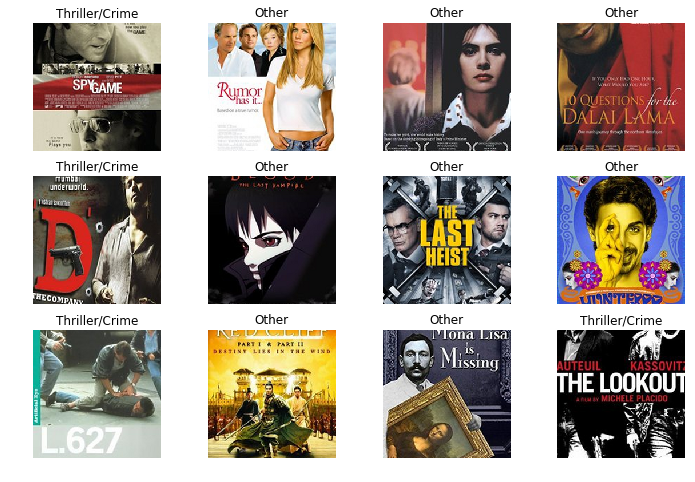

In [32]:
show_batch('valid_bi.rec')

In [35]:
ARCH = 'resnet34'
model = build_graph(ARCH)

In [37]:
model = train_fine_tuning(model, FOLDER, 0.001)

training on gpu(0)
epoch 1, train loss 0.8749, test loss 0.8390, train acc 0.535, test acc 0.545, time 31.2 sec
epoch 2, train loss 0.7989, test loss 0.7652, train acc 0.564, test acc 0.573, time 25.1 sec
epoch 3, train loss 0.7220, test loss 0.7242, train acc 0.589, test acc 0.593, time 25.2 sec
epoch 4, train loss 0.6814, test loss 0.7038, train acc 0.619, test acc 0.589, time 25.3 sec
epoch 5, train loss 0.6700, test loss 0.6961, train acc 0.634, test acc 0.625, time 25.3 sec


In [38]:
model = train_fine_tuning(model, FOLDER, 0.00001, freeze=False)

training on gpu(0)
epoch 1, train loss 0.6669, test loss 0.6970, train acc 0.626, test acc 0.625, time 25.9 sec
epoch 2, train loss 0.6574, test loss 0.6960, train acc 0.629, test acc 0.598, time 25.6 sec
epoch 3, train loss 0.6560, test loss 0.6932, train acc 0.642, test acc 0.602, time 25.6 sec
epoch 4, train loss 0.6578, test loss 0.7001, train acc 0.630, test acc 0.595, time 25.6 sec
epoch 5, train loss 0.6519, test loss 0.6970, train acc 0.639, test acc 0.598, time 25.6 sec


In [39]:
model = train_fine_tuning(model, FOLDER, 0.00001, freeze=False, scheduler=True)

training on gpu(0)
epoch 1, train loss 0.6679, test loss 0.7120, train acc 0.636, test acc 0.598, time 25.2 sec
epoch 2, train loss 0.6358, test loss 0.6958, train acc 0.647, test acc 0.600, time 25.2 sec
epoch 3, train loss 0.6344, test loss 0.6994, train acc 0.652, test acc 0.595, time 25.5 sec
epoch 4, train loss 0.6325, test loss 0.6954, train acc 0.673, test acc 0.593, time 25.4 sec
epoch 5, train loss 0.6411, test loss 0.6955, train acc 0.639, test acc 0.602, time 25.8 sec


In [40]:
model = train_fine_tuning(model, FOLDER, 0.001)

training on gpu(0)
epoch 1, train loss 7.7036, test loss 2.6372, train acc 0.551, test acc 0.625, time 25.9 sec
epoch 2, train loss 1.6656, test loss 1.6758, train acc 0.643, test acc 0.557, time 25.9 sec
epoch 3, train loss 1.2837, test loss 1.3009, train acc 0.637, test acc 0.616, time 25.7 sec
epoch 4, train loss 2.3583, test loss 1.7789, train acc 0.587, test acc 0.620, time 25.5 sec
epoch 5, train loss 1.7291, test loss 1.5493, train acc 0.633, test acc 0.591, time 25.4 sec


In [41]:
model.export(ARCH)

# Training a CNN with fastai

In [1]:
from fastai.vision import *

In [4]:
data = ImageDataBunch.from_csv(path='/home/ec2-user/SageMaker/KagglePlaygrounds', folder='', ds_tfms=get_transforms(), size=182)

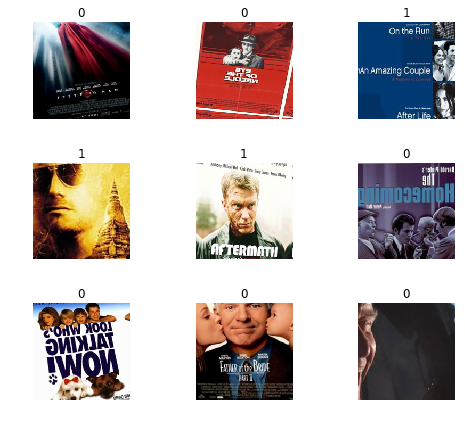

In [5]:
data.show_batch(rows=3, figsize=(7,6))

In [11]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
1,0.902920,0.743961,0.599089,03:42
2,0.809409,0.689945,0.605923,03:42
3,0.713257,0.646564,0.676538,03:41
4,0.652796,0.640856,0.685649,03:41


In [13]:
learn.save('stage-1')

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


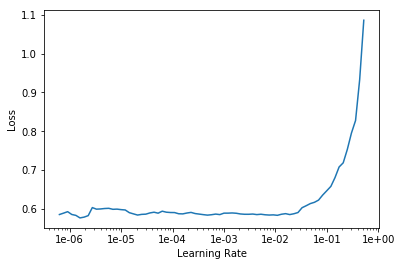

In [15]:
learn.recorder.plot()

In [16]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,accuracy,time
1,0.579383,0.636885,0.683371,05:07
2,0.575445,0.622109,0.676538,05:07
3,0.544323,0.621127,0.667426,05:08


In [17]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

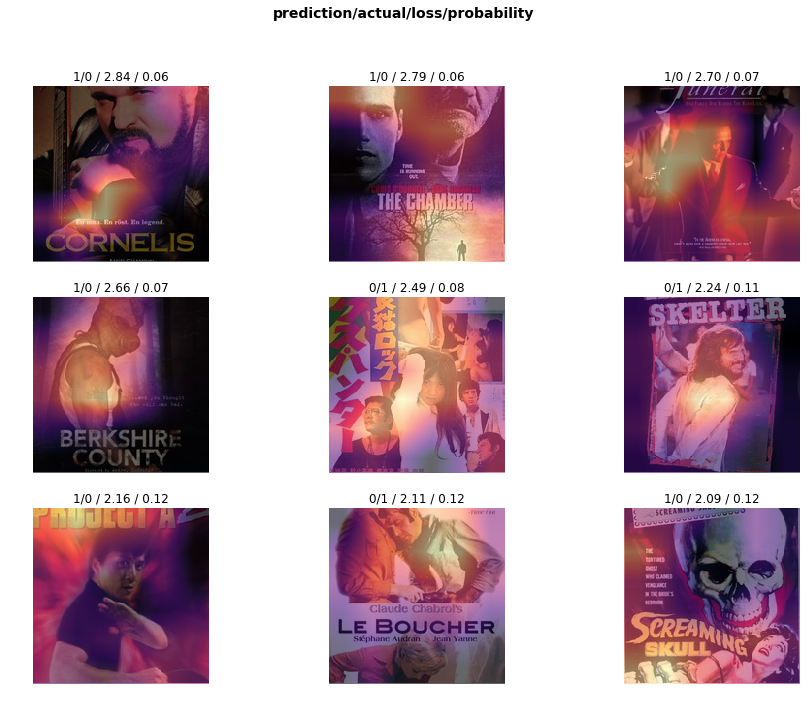

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

In [20]:
doc(interp.plot_top_losses)

_cl_int_plot_top_losses [source] _cl_int_plot_top_losses ( k , largest = True , figsize = (12, 12) , heatmap : bool = True , heatmap_thresh : int = 16 ) 
 
 Show images in top_losses along with their prediction, actual, loss, and probability of predicted class. 
 Show in docs

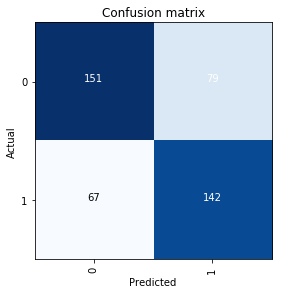

In [22]:
interp.plot_confusion_matrix(figsize=(4,4))

# Training a CNN with SageMaker (default image-classification algo)

In [42]:
%%time
import boto3
import re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()

s3_train = 's3://movies-posters-binary/train/'
s3_validation = 's3://movies-posters-binary/validation/'
bucket='s3://movies-posters-binary'

training_image = get_image_uri(boto3.Session().region_name, 'image-classification')

CPU times: user 367 ms, sys: 29.5 ms, total: 397 ms
Wall time: 2.03 s


In [43]:
%%time
from time import gmtime, strftime

s3 = boto3.client('s3')
job_name_prefix = 'is-thriller-movie'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://movies-posters-binary/output/'
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": '3,182,182',
        "num_layers": '34',
        "num_training_samples": '1758',
        "num_classes": '2',
        "mini_batch_size": '128',
        "epochs": '10',
        "learning_rate": '0.001',
        "use_pretrained_model": '0',
        "augmentation_type": 'crop_color_transform'
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_train,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_validation,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-recordio",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: is-thriller-movie-2019-02-21-18-06-52

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://movies-posters-binary/train/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 38.7 ms, sys: 0 ns, total: 38.7 ms
Wall time: 66.6 ms


In [44]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


In [45]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)

Training job ended with status: Completed


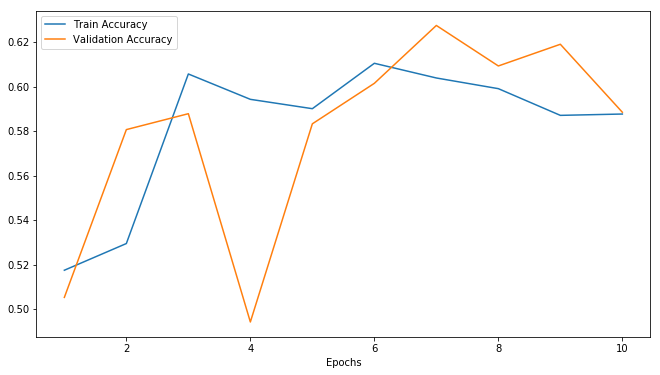

In [30]:
import boto3

client = boto3.client('logs')
lgn = '/aws/sagemaker/TrainingJobs'
lsn= 'is-thriller-movie-2019-02-21-18-06-52/algo-1-1550772609'
log = client.get_log_events(logGroupName=lgn, logStreamName=lsn)

train_acc = []
val_acc = []

for event in log['events']:
    msg = event['message']
    if 'Train-accuracy' in msg:
        train_acc.append(float(msg.split('=')[1]))
    if 'Validation-accuracy' in msg:        
        val_acc.append(float(msg.split('=')[1]))
        
train_acc = list(set(train_acc))
val_acc = list(set(val_acc))

results = pd.DataFrame({'Train Accuracy': train_acc, 'Validation Accuracy': val_acc, 'Epochs': np.arange(10)+1})

fig, ax = plt.subplots(figsize=(11,6))
results.plot(ax=ax, x='Epochs', y=['Train Accuracy', 'Validation Accuracy'])
plt.show()

### Creating prediction endpoint

In [51]:
%%time

sage = boto3.Session().client(service_name='sagemaker') 

model_name="movies-posters-model"
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

movies-posters-model
s3://movies-posters-binary/output/is-thriller-movie-2019-02-21-18-06-52/output/model.tar.gz
arn:aws:sagemaker:eu-west-1:257446244580:model/movies-posters-model
CPU times: user 55.8 ms, sys: 4.48 ms, total: 60.3 ms
Wall time: 119 ms


In [52]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: is-thriller-movie-epc--2019-02-21-18-30-16
Endpoint configuration arn:  arn:aws:sagemaker:eu-west-1:257446244580:endpoint-config/is-thriller-movie-epc--2019-02-21-18-30-16


In [53]:
%%time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: is-thriller-movie-ep--2019-02-21-18-30-19
EndpointArn = arn:aws:sagemaker:eu-west-1:257446244580:endpoint/is-thriller-movie-ep--2019-02-21-18-30-19
CPU times: user 9.9 ms, sys: 3.69 ms, total: 13.6 ms
Wall time: 214 ms


In [54]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


### Testing endpoint on a poster

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


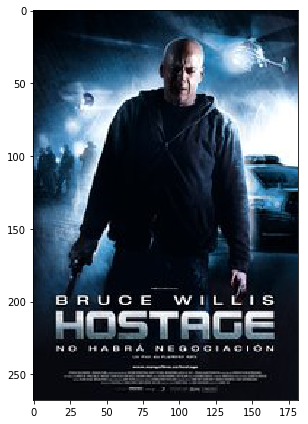

In [62]:
from skimage import io
test_image = os.path.join(FOLDER, 'posters', '340163.jpg')

fig, ax = plt.subplots(figsize=(12,6))
myimg = io.imread(test_image) 
io.imshow(myimg, ax=ax) 
io.show()

In [64]:
import json
runtime = boto3.Session().client(service_name='runtime.sagemaker')

with open(test_image, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['Non Thriller', 'Thriller']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - Thriller, probability - 0.6329127550125122


In [65]:
#sage.delete_endpoint(EndpointName=endpoint_name)